In [1]:
from bertopic import BERTopic
import cudf as pd
from sentence_transformers import SentenceTransformer
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.preprocessing.text.stem import PorterStemmer
from umap import UMAP
import seaborn as sns
import statsmodels.api as sm
import numpy as np
sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(10,10)})
from pprint import pprint

/home/jcosme/miniconda3/envs/naba/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [38]:
input_filename = 'naba_data_removed_duplicates.csv'
txt_col = "Copy/ PasteÂ An Essay Response of 500 words or less (copy and paste in webform) using the following prompt: Community disruptions such as Covid-19 and other natural disasters can have deep lasting impacts. Discuss a challenge or barrier you have overcome during the Covid-19 pandemic."
label_col = 'Recipient'

reg_sig_topic_coef_filename = 'significant_topic_coeffs.csv'
reg_topics_filename = 'reg_topics_inputs_df.csv'
norm_topics_filename = 'norm_topic_count_df.csv'

In [3]:
random_seed = 42

sentence_model = SentenceTransformer(
    "all-mpnet-base-v2", 
    device="cuda",
)

umap = UMAP(
    random_state=random_seed, 
    n_components=1,
)


topic_model = BERTopic(
    embedding_model=sentence_model,
    top_n_words=6, 
    diversity=1,
    n_gram_range=(1, 1),
    min_topic_size=10,
    nr_topics='auto',
    # calculate_probabilities=True,
    umap_model=umap,
)

p_alpha = 0.1
k_topics = 5

In [4]:
df = pd.read_csv(input_filename)

In [5]:
df.head()

app_id  \
0       0   
1       1   
2       2   
3       3   
4       4   

  Gender:* Required fields are indicated with red symbol Permanent Contact Information  \
0                                               Male                                     
1                                             Female                                     
2                                             Female                                     
3                                             Female                                     
4                                               Male                                     

  City (Permanent):* Required fields are indicated with red symbol Permanent Contact Information   \
0                                           Brooklyn                                                
1                                              Bowie                                                
2                                    Chicago Heights                                                
3                                            Chicago                                                
4                                        Baton Rouge                                                

  State (Permanent):* Required fields are indicated with red symbol Permanent Contact Information  \
0                                                 NY                                                
1                                                 MD                                                
2                                                 IL                                                
3                                                 IL                                                
4                                                 LA                                                

  Zip (Permanent):* Required fields are indicated with red symbol Permanent Contact Information  \
0                                              11216                                              
1                                              20720                                              
2                                              60411                                              
3                                              60620                                              
4                                              70806                                              

  Are you Black? (includes African, African American, Caribbean, etc.)  \
0                                                Yes                     
1                                                Yes                     
2                                                Yes                     
3                                                Yes                     
4                                                Yes                     

  Preferred Mailing Address  College/University:Academic Profile  \
0                 Permanent                 Medgar Evers College   
1                 Permanent               University of Maryland   
2                 Permanent  North Carolina A&T State University   
3                 Permanent            Loyola University Chicago   
4          Campus/Temporary                Penn State University   

  Classification (as of January 2022):Academic Profile Major:Academic Profile  \
0                                             Senior               Accounting   
1                                           Freshman      Business Management   
2                                           Freshman               Accounting   
3                                          Sophomore               Accounting   
4                                          Sophomore               Accounting   

   ... Please provide details (i.e. company name, location, etc.)  \
0  ...                                               <NA>           
1  ...  Received internship as a Summer 2022 Discovery...           
2  ...                    

## Topic modeling

In [6]:
# correct the labels column
labels_df = df[label_col].copy()
labels_df

0      <NA>
1      <NA>
2      <NA>
3      <NA>
4       Yes
       ... 
195     Yes
196    <NA>
197    <NA>
198    <NA>
199     Yes
Name: Recipient, Length: 200, dtype: object

In [7]:
labels_df[labels_df.notnull()] = 1.0
labels_df

0      <NA>
1      <NA>
2      <NA>
3      <NA>
4       1.0
       ... 
195     1.0
196    <NA>
197    <NA>
198    <NA>
199     1.0
Name: Recipient, Length: 200, dtype: object

In [8]:
labels_df[labels_df.isna()] = 0.0
labels_df = labels_df.astype('float')
labels_df

0      0.0
1      0.0
2      0.0
3      0.0
4      1.0
      ... 
195    1.0
196    0.0
197    0.0
198    0.0
199    1.0
Name: Recipient, Length: 200, dtype: float64

In [9]:
labels_df.value_counts()

1.0    110
0.0     90
Name: Recipient, dtype: int32

In [10]:
df[label_col] = labels_df

In [11]:
# check for duplicate paragraphs
n_rows = df.shape[0]
print(f"total number of applications: {n_rows}")
n_unq_paras = df[txt_col].drop_duplicates().shape[0]
print(f"total number of UNIQUE paragraphs: {n_unq_paras}")
has_no_duplicate_paras = n_rows == n_unq_paras
print(f"are there no duplicate paragraphs?: {has_no_duplicate_paras}")

total number of applications: 200
total number of UNIQUE paragraphs: 200
are there no duplicate paragraphs?: True


In [12]:
# normalize spaces: Remove extra whitespace between tokens and trim whitespace from the beginning and the end of each string.
df[txt_col] = df[txt_col].str.normalize_spaces()

In [13]:
# create a colum for how many words in each paragraph
df['txt_len'] = df[txt_col].str.split().list.len()

In [14]:
# replace any 'N/A' values with empty strings
total_na = df[txt_col].copy().isna().sum()
print(f"total empty count: {total_na}")
print(df.loc[df[txt_col].isna(), txt_col])
df.loc[df[txt_col].isna(), txt_col] = ''
total_na = df[txt_col].copy().isna().sum()
print(f"new total empty count: {total_na}")

total empty count: 1
    Copy/ PasteÂ An Essay Response of 500 words or less (copy and paste in webform) using the following prompt: Community disruptions such as Covid-19 and other natural disasters can have deep lasting impacts. Discuss a challenge or barrier you have overcome during the Covid-19 pandemic.
146                                               <NA>                                                                                                                                                                                                                                          
new total empty count: 0


In [15]:
# df

In [16]:
# split each paragraph into sentences
sentences_df = df[txt_col].copy() + ' '
sentences_df = sentences_df.str.replace('Dr.', 'doctor', regex=False) # I saw this abbreviation so i'm just replacing it
senc_per_paragraph = sentences_df.str.split(pat='[!.?] ', regex=True).list.len()
sentences_df = sentences_df.str.split(pat='[!.?] ', regex=True, expand=True) # we assume sentences end in '.' '?' or '!' so we split on these
sentences_df = sentences_df.fillna('') # replace NA with empty strings
max_n_sencs = sentences_df.shape[1]
n_rows = sentences_df.shape[0]
sentences_df

0   \
0    During the early parts of 2020 one of the dead...   
1    One of the most challenging times has been dur...   
2    When covid restrictions took place I was just ...   
3    When the Covid-19 pandemic first began, I was ...   
4    Community disruptions such as Covid-19 and oth...   
..                                                 ...   
195  There are many issues that are impacting the a...   
196  My name is Wunmi Surakat, a current 1st semest...   
197             No one expected the Covid- 19 pandemic   
198  During the COVID-19 pandemic, my entire life c...   
199  The Covid-19 pandemic is something that has af...   

                                                    1   \
0    This pandemic has bedeviled me with many hurdl...   
1    It truly had an impact on my family emotionall...   
2    In March of 2020, that was the last time I wou...   
3    In the Fall of 2020, I started college with th...   
4    The Covid-19 pandemic has taught us that disru...   
..                                                 ...   
195  I believe one of the most important issues is ...   
196  At the start of the COVID-19 pandemic, I was i...   
197  Since it happened it has opened my eyes and ma...   
198  I made an 180 degree turn in my life, finally ...   
199  As a recent graduate and being in the first se...   

                                                    2   \
0    The most difficult barrier I've had to overcom...   
1    My father lost his employment in an industry t...   
2    Because of the coronavirus people began to los...   
3    Starting my first year of college online made ...   
4    As such, we are to remain vigilant and always ...   
..                                                 ...   
195  When talking about, Covid-19 it has impacted m...   
196  I remembered clearly, I was on Spring Break in...   
197  The pandemic has affected my life in many ways...   
198  I went from extremely motivated, bubbly, energ...   
199  I came to college in 2018, so I only had one i...   

                                                    3   \
0    As an international transfer student from Guya...   
1      This did have a significant burden on my family   
2    So, here I am about seventeen years old, worki...   
3    Instead, I was faced with attending classes on...   
4                  Covid-19 has had a big impact on me   
..                                                 ...   
195  Challenges and barriers that I have had to ove...   
196  After spring break was over, all my classes we...   
197  One challenge that I had to face was my bigges...   
198  I moved from across the country to a universit...   
199  When I first came to college, I was always the...   

                                                    4   \
0    I only had the privilege to experience what it...   
1    Additionally, I developed Covid-19 this fall s...   
2    I ended up quitting sports and extra activitie...   
3    With Zoom, it was a rocky start with getting u...   
4    I have been affected financially, psychologica...   
..                                                 ...   
195     Learning is an essential part of everyday life   
196  Learning online became the biggest challenge a...   
197  I had a fear of going to college because at th...   
198  I faced several low points in my life during t...   
199  When my university went virtual, that took awa...   

                                                    5   \
0    Never in my life prior to covid have I taken a...   
1    This did have an impact on my GPA and caused m...   
2    This was extremely hard for me because in Marc...   
3    It was also much more difficult to really enjo...   
4    Like many other students, I painfully grappled...   
..                                                 ...   
195  It is the process behind acquiring a new under...   
196  For the past 18years of my life, I had In-pers...   
197  After losing my mother at such an early 

In [17]:
# stack all the sentences into one column
sentences_series = sentences_df.copy().stack().reset_index(drop=True)
sentences_series = sentences_series.str.normalize_spaces()
sentences_series

0       During the early parts of 2020 one of the dead...
1       This pandemic has bedeviled me with many hurdl...
2       The most difficult barrier I've had to overcom...
3       As an international transfer student from Guya...
4       I only had the privilege to experience what it...
                              ...                        
8595                                                     
8596                                                     
8597                                                     
8598                                                     
8599                                                     
Length: 8600, dtype: object

In [18]:
# preprocess the sentences:
# 1. remove all non-letter character
# 2. remove all english 'stop words' (words like 'the' 'I' 'may' 'this' 'him' basically words that don't add meaning to sentences
# 3. stem all words (for example 'moving', 'moved', and 'move' would all be changed to 'mov'

# load word stemmer 
stemmer = PorterStemmer()
# get stop words from tfidf
tfidf = TfidfVectorizer(stop_words='english')
stop_words = tfidf._get_stop_words() # stop words will be removed
del tfidf

def preproc_senc_srs(a_series):
    preproc_sentences_series = a_series.copy()
    
    # remove all non-alpbabet characters
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces().str.lower().str.replace('[^A-Za-z\s]', '', regex=True)
    
    # remove each stop word
    for stop_word in stop_words:
        preproc_sentences_series = preproc_sentences_series.str.replace(fr'\b{stop_word}\b', '', regex=True)
        
    # stem each word
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces()
    preproc_sentences_series = preproc_sentences_series + ' -'
    sen_lens = preproc_sentences_series.str.split().list.len()
    sen_index = sen_lens.index.repeat(sen_lens)
    preproc_sentences_series = stemmer.stem(preproc_sentences_series.str.tokenize()).str.detokenize(sen_index)
    preproc_sentences_series = preproc_sentences_series.str.replace('-', '')
    preproc_sentences_series = preproc_sentences_series.str.normalize_spaces()
    
    return preproc_sentences_series

In [19]:
preproc_sentences_series = preproc_senc_srs(sentences_series)

In [20]:
preproc_sentences_series 

0       earli part deadliest virus plagu world novel c...
1         pandem bedevil hurdl overcom drastic chang life
2       difficult barrier ive overcom get simul new co...
3       intern transfer student guyana extrem difficul...
4       privileg experi felt like attend class campu m...
                              ...                        
8595                                                     
8596                                                     
8597                                                     
8598                                                     
8599                                                     
Length: 8600, dtype: object

In [21]:
# get the labels
y_series = sentences_df.copy().set_index(df[label_col])
y_series = y_series.stack().reset_index().sort_values('level_1')[preproc_sentences_series.str.len() != 0]['level_0'].astype(int)
y_series

0       0
43      0
86      0
129     0
172     1
       ..
7223    1
7266    1
7309    0
7352    1
7395    1
Name: level_0, Length: 4019, dtype: int64

In [22]:
# drop all empty rows for fitting model
docs = preproc_sentences_series[preproc_sentences_series.str.len() != 0]
docs

0       earli part deadliest virus plagu world novel c...
1         pandem bedevil hurdl overcom drastic chang life
2       difficult barrier ive overcom get simul new co...
3       intern transfer student guyana extrem difficul...
4       privileg experi felt like attend class campu m...
                              ...                        
8567    feel unmotiv taken toll mental health way caus...
8568    overcom challeng thought barrier success push ...
8569    famili colleg path corpor world creat legaci f...
8570    continu strive new height daili reach potenti ...
8571    understand purpos challeng face allow experi m...
Length: 4019, dtype: object

In [23]:
# turn Series into a list; move from GPU to CPU
docs = docs.to_arrow().to_pylist()
y = y_series.to_arrow().to_pylist()

In [24]:
# fit the topic model
topic_model.fit(docs, y=y)

In [25]:
# show topics and topic counts 
topic_model.get_topic_info()

Topic  Count                                     Name
0      -1    406                  -1_pandem_new_way_adapt
1       0   1949                 0_school_abl_way_overcom
2       1    402            1_colleg_pandem_event_virtual
3       2    195         2_friend_transit_difficult_enjoy
4       3     69                 3_cpa_summer_attend_said
5       4     56                  4_focus_riot_grip_giant
6       5     54         5_crochet_ignor_normal_uncertain
7       6     51  6_internship_environ_assign_remotelearn
8       7     50               7_limit_bang_enjoy_mindset
9       8     50          8_depress_deal_anxieti_unexpect
10      9     47   9_psycholog_detentionassoci_age_differ
11     10     46             10_therapist_ive_issu_pandem
12     11     38           11_barrier_thousand_major_have
13     12     37       12_scholarship_theta_priorit_local
14     13     35             13_racial_georg_inequ_vaccin
15     14     34            14_learn_doesnt_crowd_guylain
16     15     29      15_hardship_morn_pennsylvania_caddi
17     16     28           16_adapt_specialti_feder_april
18     17     27            17_zoom_class_roof_monetarili
19     18     26               18_hobbi_keyword_wasnt_rid
20     19     25          19_diet_instagram_recoveri_dark
21     20     22              20_pandem_forc_stream_spong
22     21     22             21_indoor_well_boredom_typic
23     22     21     22_trajectori_financ_endless_connect
24     23     21   23_interrupt_father_overcom_strengthen
25     24     20           24_pay_soloist_shook_technolog
26     25     19         25_gift_makeawish_pioneer_spring
27     26     19        26_healthcar_unchart_utah_chariti
28     27     18           27_ghana_graduat_transpir_hate
29     28     17         28_sarcast_want_valdosta_smaller
30     29     17             29_make_leverag_knew_anticip
31     30     16             30_covid_dimens_student_rule
32     31     16     31_globallycovid_valley_take_struggl
33     32     16          32_laidoff_fjhcdn_costli_daycar
34     33     15                 33_employ_sang_grim_ball
35     34     14          34_pattern_spectrum_feel_kidney
36     35     14           35_peopleperson_went_mayb_halt
37     36     13           36_healthi_unless_peru_overtim
38     37     12       37_overli_everchang_conclus_bigger
39     38     12        38_wearili_retaught_abl_yesterday
40     39     11     39_global_unvaccin_reachdeath_belief
41     40     10               40_uber_moment_hone_repres
42     41     10  41_havent_awkwardli_uneas_focuseddriven
43     42     10      42_monotoni_breastf_teammat_struggl

In [26]:
n_topics = topic_model.get_topic_info().shape[0] - 1
n_topics

43

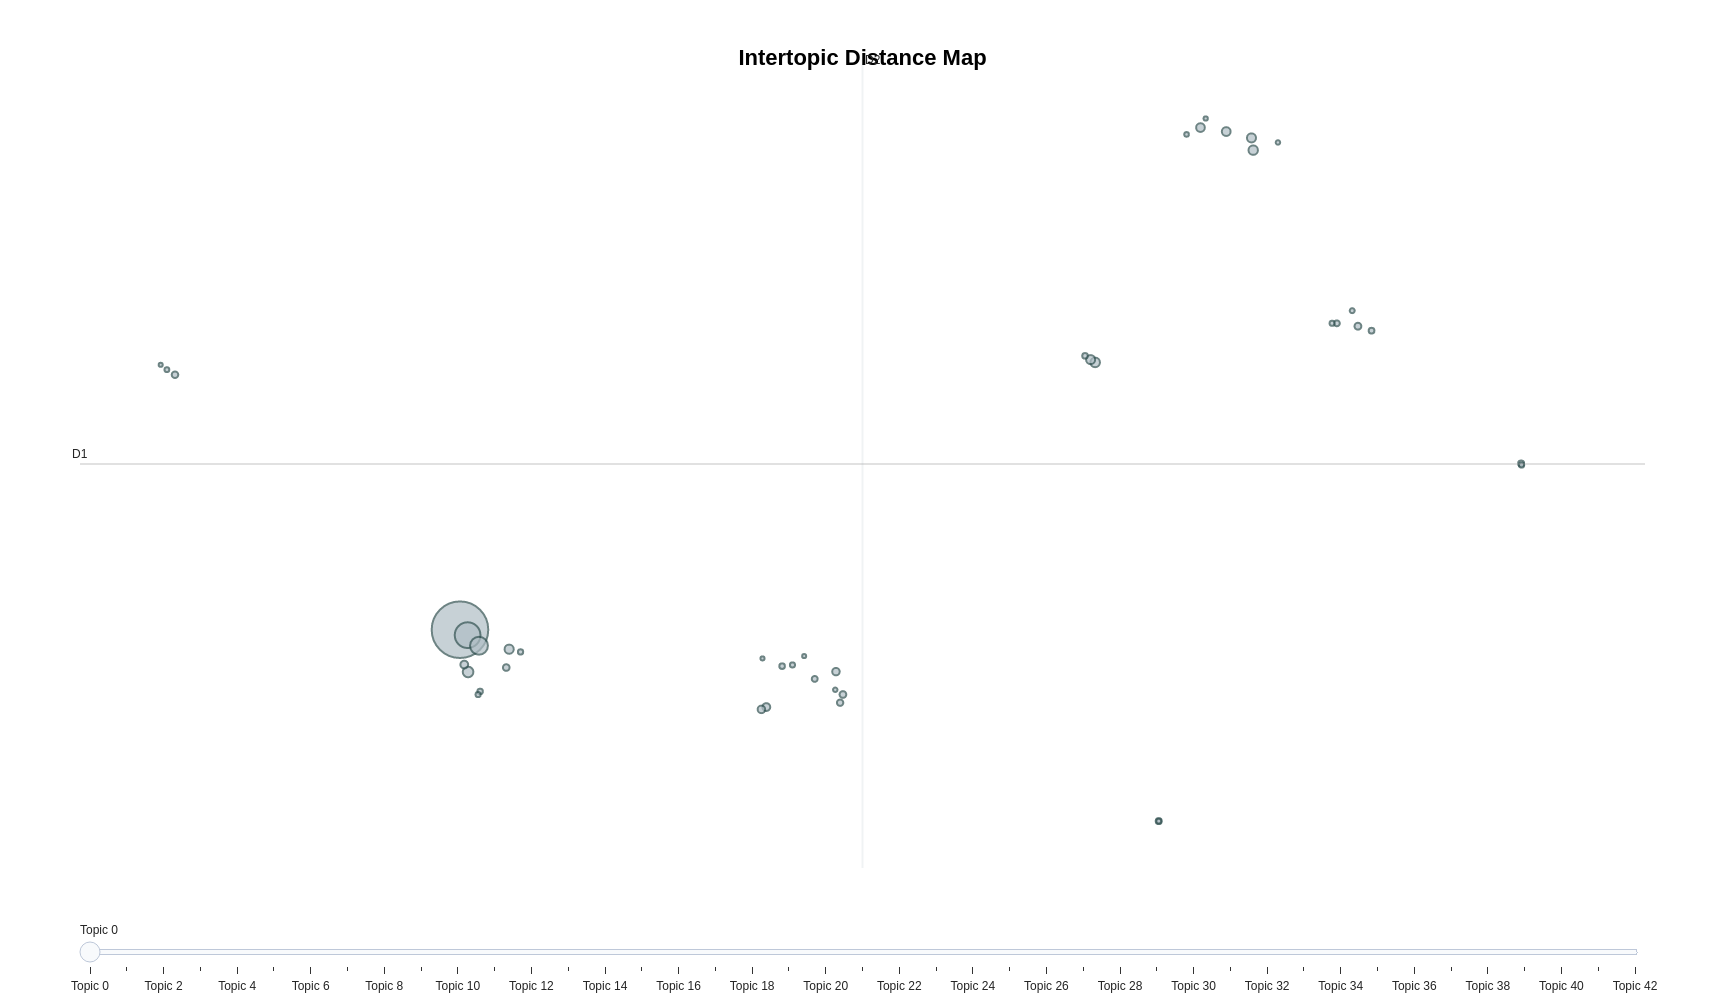

In [27]:
# plot topic distance map
topic_model.visualize_topics(width=1000, height=1000)

In [28]:
# save plot of topic distance map
# topic_model.visualize_topics(width=1000, height=1000).write_html("visualize_topics.html")

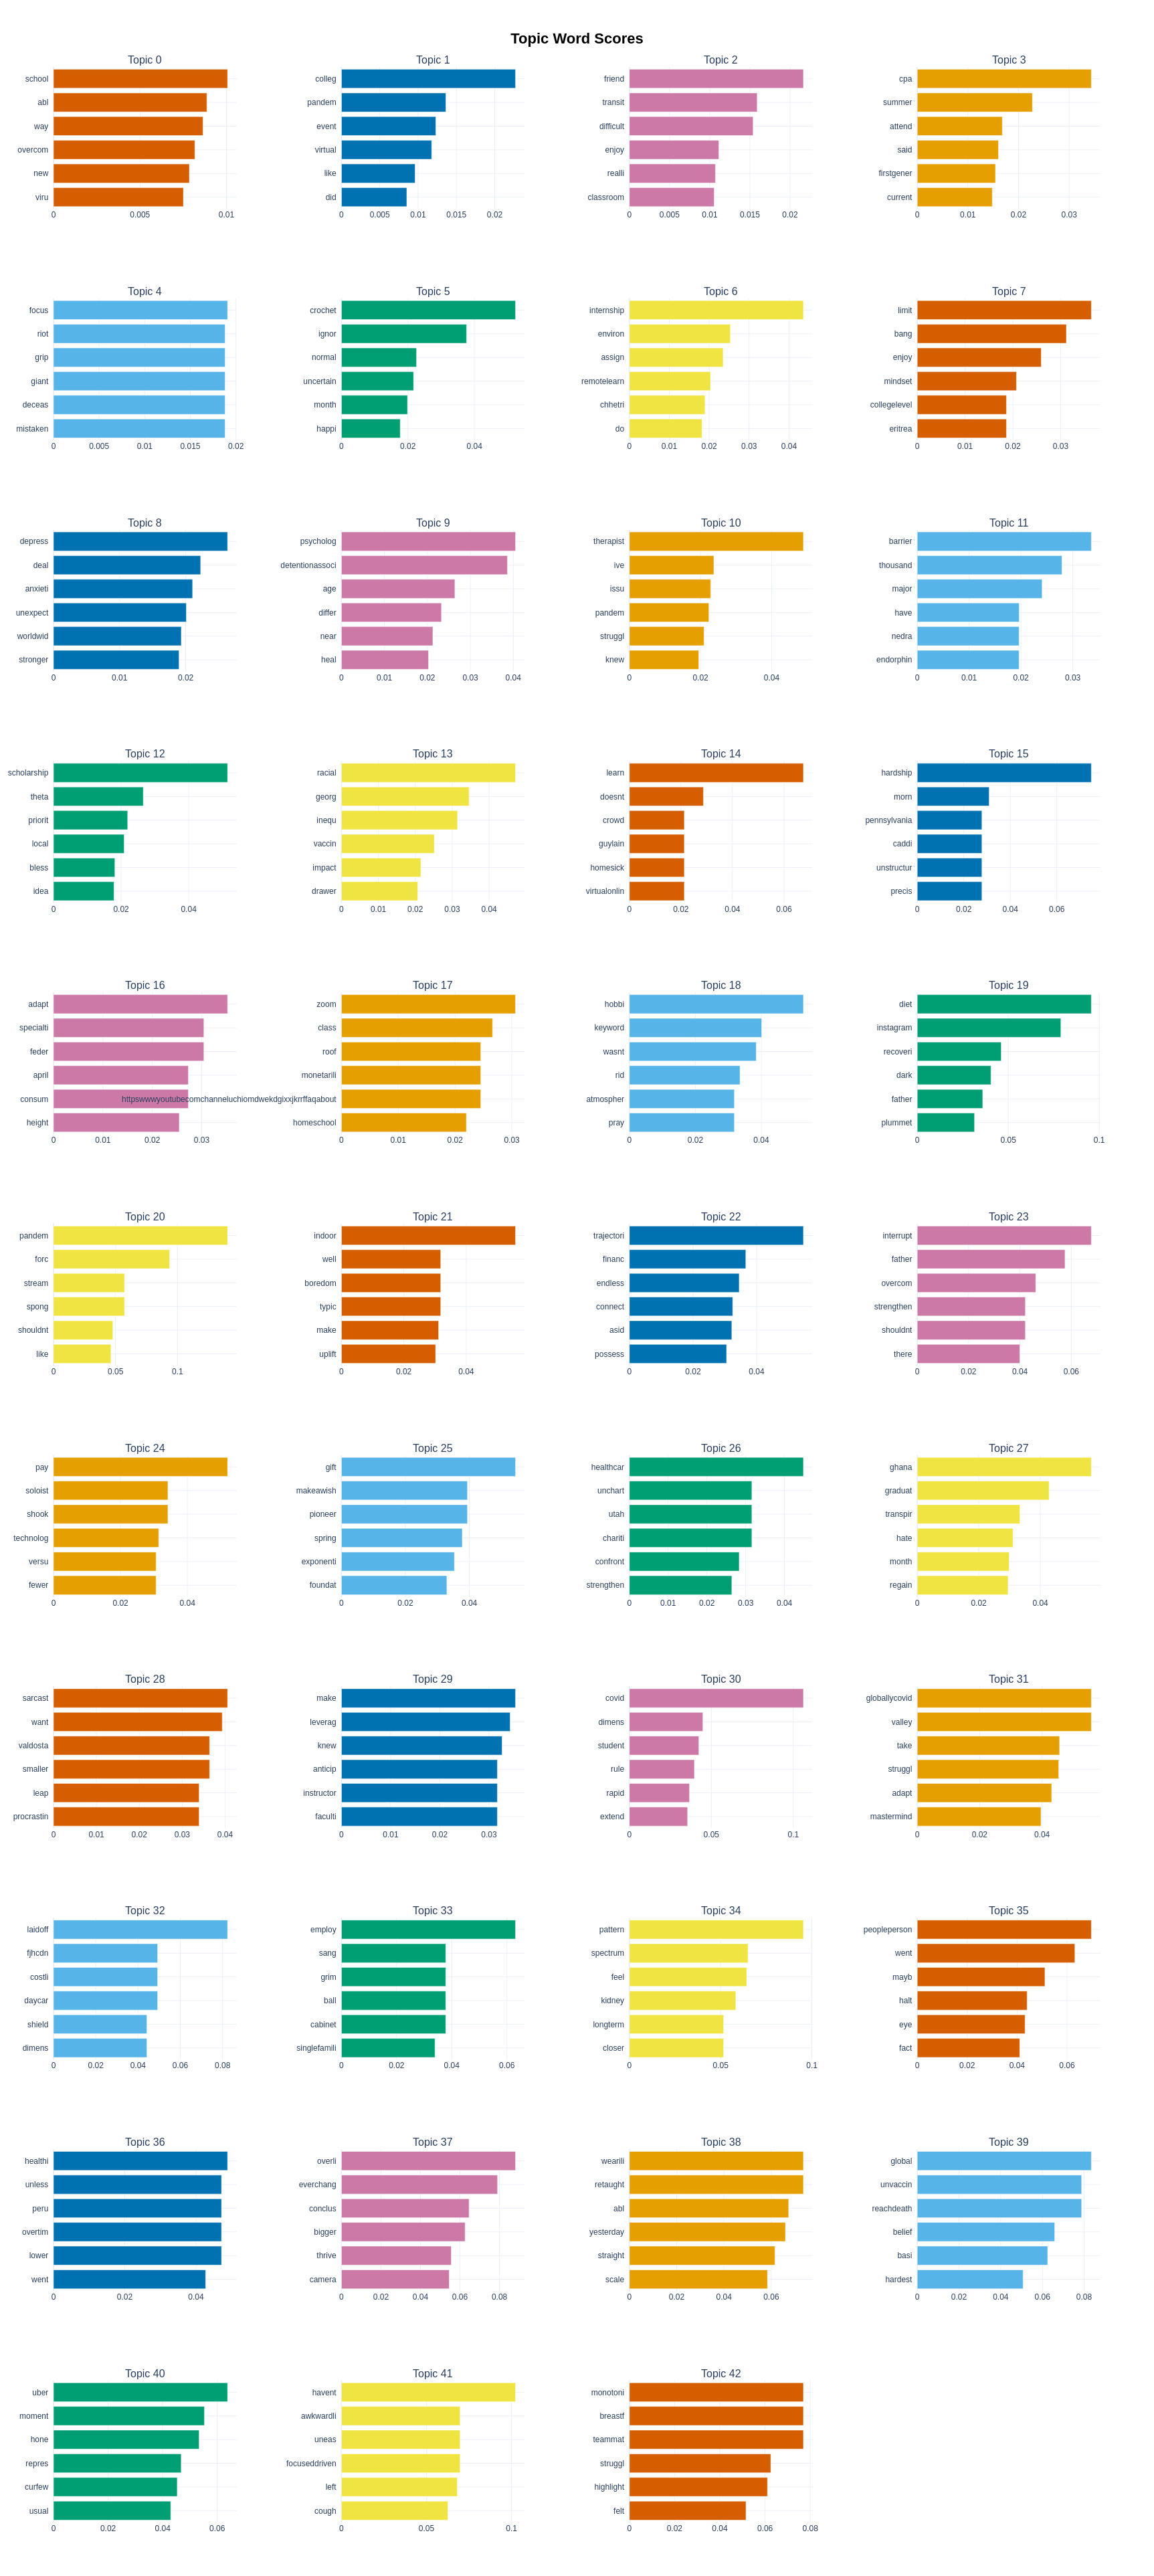

In [29]:
# show words for each topic
topic_model.visualize_barchart(top_n_topics=topic_model.get_topic_info().shape[0], n_words=10, height=350, width=400)

In [30]:
# save plot of words for each topic
# topic_model.visualize_barchart(top_n_topics=topic_model.get_topic_info().shape[0], n_words=10, height=350, width=400).write_html('visualize_barchart.html')

In [31]:
# label each sentence with a topic
docs = preproc_sentences_series.to_arrow().to_pylist()
doc_topics, topic_probs = topic_model.transform(docs)

In [32]:
# perform topic hierarchy analysis
docs = preproc_sentences_series[preproc_sentences_series.str.len() != 0]
docs = docs.to_arrow().to_pylist()
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|███████████████████████████████████████████| 42/42 [00:00<00:00, 50.00it/s]


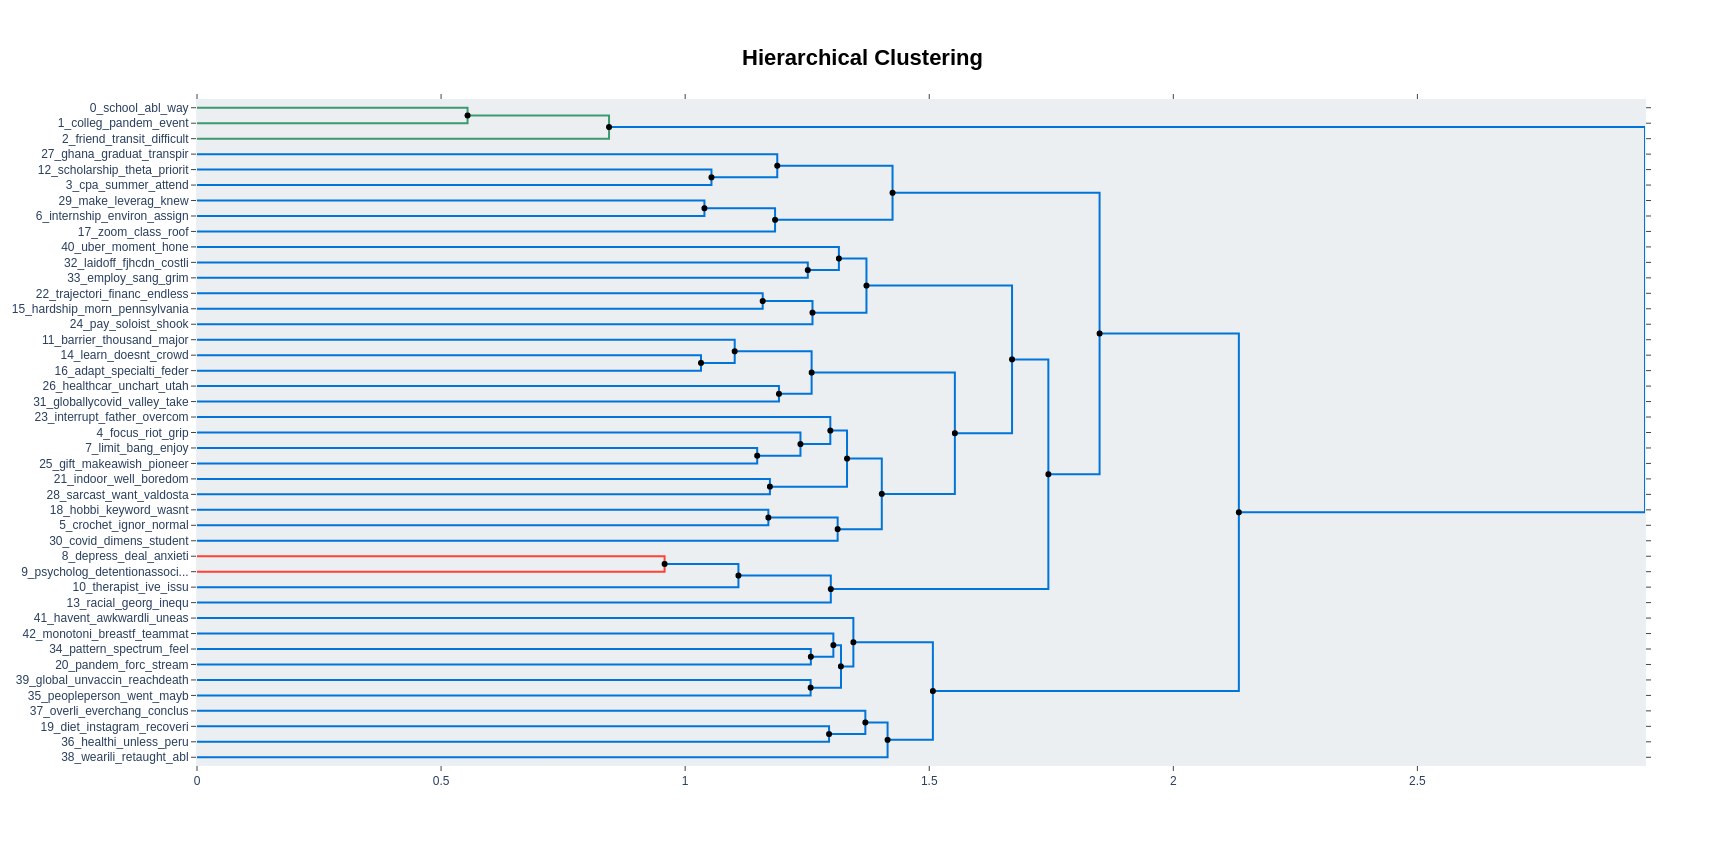

In [33]:
# plot topic hierarchy
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [34]:
# save plot of topic hierarchy
# topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics).write_html('visualize_heirarchy.html')

In [35]:
# create a dataframe that categorizes each sentence
topics_series = pd.Series(doc_topics).astype(str)

col_index = []
for i in range(n_rows):
    col_index.extend([i] * max_n_sencs)
    
senc_topics_df = topics_series.str.detokenize(pd.Series(col_index)).str.split(expand=True)
senc_topics_df = senc_topics_df.rename(columns={x: f'senc_{str(x)}' for x in senc_topics_df.columns})
senc_topics_df

senc_0 senc_1 senc_2 senc_3 senc_4 senc_5 senc_6 senc_7 senc_8 senc_9  \
0        0      0      0      0     -1      0      0      2      0      0   
1        0     15     -1      0     -1     -1      0      0      3      0   
2       -1      0      0      0     -1      0     -1      0      1      3   
3        0      0      0      2      0      2      0     -1     -1      3   
4        0     -1     -1      0     10      0      0      0     -1     -1   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
195      0      0      0      0     -1      0      1     37      0      6   
196     33      0      0      0     -1      0      2     -1     -1     37   
197     -1     -1      0     -1      0     -1     -1      1     -1     37   
198      0     -1      0      0      0      0     -1     -1     -1      0   
199     -1      0      0     -1      0     37      0     -1     -1      1   

     ... senc_33 senc_34 senc_35 senc_36 senc_37 senc_38 senc_39 senc_40  \
0    ...      -1      -1      -1      -1      -1      -1      -1      -1   
1    ...      -1      -1      -1      -1      -1      -1      -1      -1   
2    ...      -1      -1      -1      -1      -1      -1      -1      -1   
3    ...      -1      -1      -1      -1      -1      -1      -1      -1   
4    ...      -1      -1      -1      -1      -1      -1      -1      -1   
..   ...     ...     ...     ...     ...     ...     ...     ...     ...   
195  ...      -1      -1      -1      -1      -1      -1      -1      -1   
196  ...      -1      -1      -1      -1      -1      -1      -1      -1   
197  ...      -1      -1      -1      -1      -1      -1      -1      -1   
198  ...      -1      -1      -1      -1      -1      -1      -1      -1   
199  ...      -1      -1      -1      -1      -1      -1      -1      -1   

    senc_41 senc_42  
0        -1      -1  
1        -1      -1  
2        -1      -1  
3        -1      -1  
4        -1      -1  
..      ...     ...  
195      -1      -1  
196      -1      -1  
197      -1      -1  
198      -1      -1  
199      -1      -1  

[200 rows x 43 columns]

In [36]:
# count of each topic per paragraphs

topic_count_df = pd.DataFrame(index=range(n_rows), columns=range(n_topics))
for i in range(n_rows):
    temp_df = senc_topics_df.iloc[i].reset_index(drop=True).T.value_counts().sort_index().to_frame().T
    temp_df = temp_df[temp_df.columns[1::]]
    temp_df.columns = temp_df.columns.to_frame()[0].values
    topic_count_df.loc[i, temp_df.columns.astype(int)] = temp_df.values.flatten()
topic_count_df = topic_count_df.fillna(0)
topic_count_df = topic_count_df.rename(columns={x: f'topic_{str(x)}' for x in topic_count_df.columns})
topic_count_df


topic_0 topic_1 topic_2 topic_3 topic_4 topic_5 topic_6 topic_7 topic_8  \
0        12       0       1       0       0       0       0       0       0   
1         6       0       0       1       0       0       0       0       0   
2         5       1       0       1       0       0       0       0       0   
3         8       0       3       1       0       0       0       0       0   
4        15       0       0       0       0       0       0       0       0   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
195      15       1       0       0       0       0       1       0       0   
196       9       0       1       1       0       0       0       0       0   
197       6       2       2       0       0       0       0       0       0   
198      14       0       0       0       1       0       0       1       0   
199       5       1       0       0       0       0       0       0       0   

    topic_9  ... topic_33 topic_34 topic_35 topic_36 topic_37 topic_38  \
0         0  ...        1        0        0        0        1        0   
1         0  ...        0        0        0        0        0        0   
2         0  ...        0        0        0        0        0        0   
3         0  ...        0        0        0        0        0        0   
4         1  ...        0        0        0        0        1        0   
..      ...  ...      ...      ...      ...      ...      ...      ...   
195       0  ...        0        0        0        0        1        0   
196       0  ...        1        0        0        0        1        0   
197       0  ...        0        0        0        0        3        0   
198       0  ...        0        0        0        0        0        0   
199       0  ...        0        0        0        0        1        1   

    topic_39 topic_40 topic_41 topic_42  
0          0        0        0        0  
1          0        0        0        0  
2          0        0        0        0  
3          0        0        0        0  
4          0        0        0        0  
..       ...      ...      ...      ...  
195        0        0        0        0  
196        0        0        0        0  
197        0        0        0        0  
198        0        0        0        0  
199        0        0        0        0  

[200 rows x 43 columns]

In [37]:
# normalize each topic count by number of sentences in paragraphs
norm_topic_count_df = topic_count_df.astype('float')# + 1e-8
for a_col in norm_topic_count_df.columns:
    norm_topic_count_df[a_col] = norm_topic_count_df[a_col] / senc_per_paragraph
norm_topic_count_df[norm_topic_count_df.isna()] = 0
norm_topic_count_df

topic_0   topic_1   topic_2   topic_3   topic_4  topic_5   topic_6  \
0    0.631579  0.000000  0.052632  0.000000  0.000000      0.0  0.000000   
1    0.500000  0.000000  0.000000  0.083333  0.000000      0.0  0.000000   
2    0.454545  0.090909  0.000000  0.090909  0.000000      0.0  0.000000   
3    0.444444  0.000000  0.166667  0.055556  0.000000      0.0  0.000000   
4    0.500000  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
..        ...       ...       ...       ...       ...      ...       ...   
195  0.652174  0.043478  0.000000  0.000000  0.000000      0.0  0.043478   
196  0.409091  0.000000  0.045455  0.045455  0.000000      0.0  0.000000   
197  0.260870  0.086957  0.086957  0.000000  0.000000      0.0  0.000000   
198  0.500000  0.000000  0.000000  0.000000  0.035714      0.0  0.000000   
199  0.312500  0.062500  0.000000  0.000000  0.000000      0.0  0.000000   

      topic_7  topic_8   topic_9  ...  topic_33  topic_34  topic_35  topic_36  \
0    0.000000      0.0  0.000000  ...  0.052632       0.0       0.0       0.0   
1    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
2    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
3    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
4    0.000000      0.0  0.033333  ...  0.000000       0.0       0.0       0.0   
..        ...      ...       ...  ...       ...       ...       ...       ...   
195  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
196  0.000000      0.0  0.000000  ...  0.045455       0.0       0.0       0.0   
197  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
198  0.035714      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
199  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   

     topic_37  topic_38  topic_39  topic_40  topic_41  topic_42  
0    0.052632    0.0000       0.0       0.0       0.0       0.0  
1    0.000000    0.0000       0.0       0.0       0.0       0.0  
2    0.000000    0.0000       0.0       0.0       0.0       0.0  
3    0.000000    0.0000       0.0       0.0       0.0       0.0  
4    0.033333    0.0000       0.0       0.0       0.0       0.0  
..        ...       ...       ...       ...       ...       ...  
195  0.043478    0.0000       0.0       0.0       0.0       0.0  
196  0.045455    0.0000       0.0       0.0       0.0       0.0  
197  0.130435    0.0000       0.0       0.0       0.0       0.0  
198  0.000000    0.0000       0.0       0.0       0.0       0.0  
199  0.062500    0.0625       0.0       0.0       0.0       0.0  

[200 rows x 43 columns]

In [39]:
norm_topic_count_df.to_csv(norm_topics_filename, index=False)

In [40]:
# # change count to binary value (1 means topic is included, 0 means topic is not included)
# topic_count_df = topic_count_df.astype('float')
# topic_count_df[topic_count_df > 1] = 1
# topic_count_df


# norm_topic_count_df = topic_count_df.copy()
# norm_topic_count_df

<AxesSubplot: >

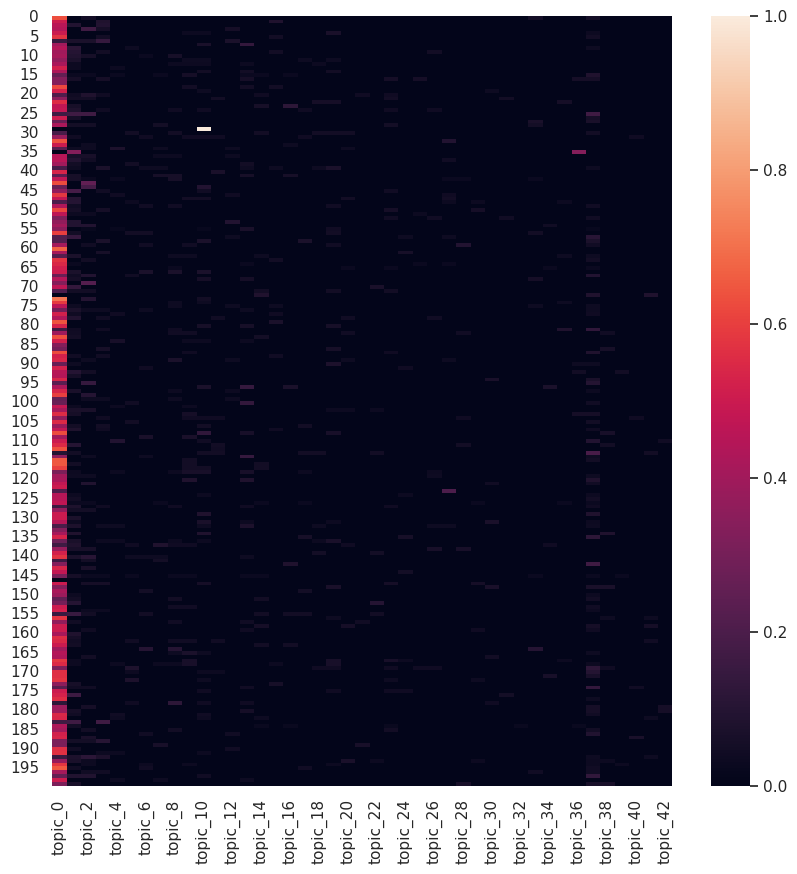

In [41]:
# heatmap of percent of topics in a paragraph
sns.set(rc={'figure.figsize':(10,10)})
sns.heatmap(norm_topic_count_df.to_pandas())

In [42]:
# sns.set(rc={'figure.figsize':(20,60)})
# sns.heatmap(norm_topic_count_df.to_pandas())

In [43]:
avg_norm_topic_count_df = norm_topic_count_df.sum(axis=0) / norm_topic_count_df.shape[0]
# avg_norm_topic_count_df

<AxesSubplot: >

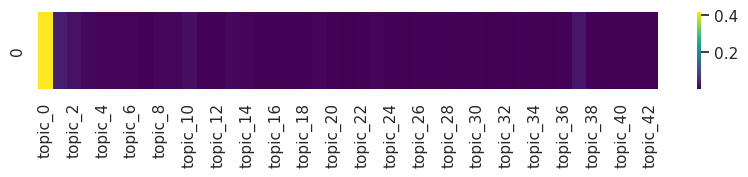

In [44]:
# heatmap of AVERAGE percent of topics in a paragraph
sns.set(rc={'figure.figsize':(10,1)})
sns.heatmap(avg_norm_topic_count_df.to_frame().T.to_pandas(), cmap=sns.color_palette("viridis", as_cmap=True))

<AxesSubplot: >

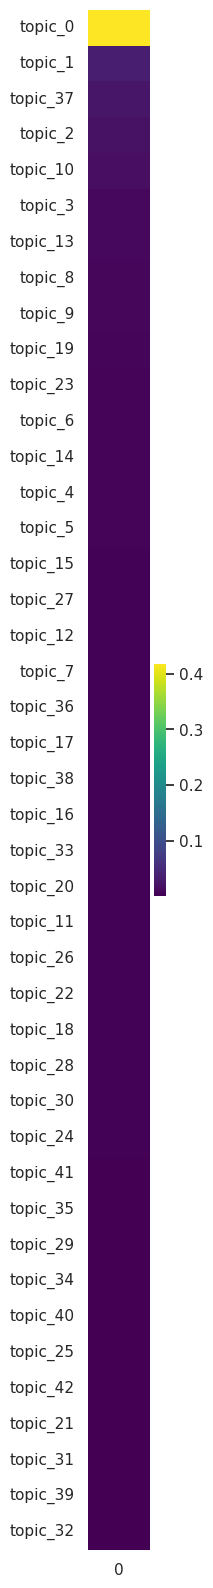

In [45]:
# heatmap of AVERAGE percent of topics in a paragraph, sorted by descending values
sns.set(rc={'figure.figsize':(1,20)})
sns.heatmap(avg_norm_topic_count_df.sort_values(ascending=False).to_frame().to_pandas(), cmap=sns.color_palette("viridis", as_cmap=True))

In [46]:
# create a variable for the name of the column that contains the labels
labels_df = df[label_col].copy().astype(int)
labels_df

0      0
1      0
2      0
3      0
4      1
      ..
195    1
196    0
197    0
198    0
199    1
Name: Recipient, Length: 200, dtype: int64

In [47]:
norm_topic_count_df.to_pandas().to_csv(reg_topics_filename, index=False)
norm_topic_count_df.to_pandas()

topic_0   topic_1   topic_2   topic_3   topic_4  topic_5   topic_6  \
0    0.631579  0.000000  0.052632  0.000000  0.000000      0.0  0.000000   
1    0.500000  0.000000  0.000000  0.083333  0.000000      0.0  0.000000   
2    0.454545  0.090909  0.000000  0.090909  0.000000      0.0  0.000000   
3    0.444444  0.000000  0.166667  0.055556  0.000000      0.0  0.000000   
4    0.500000  0.000000  0.000000  0.000000  0.000000      0.0  0.000000   
..        ...       ...       ...       ...       ...      ...       ...   
195  0.652174  0.043478  0.000000  0.000000  0.000000      0.0  0.043478   
196  0.409091  0.000000  0.045455  0.045455  0.000000      0.0  0.000000   
197  0.260870  0.086957  0.086957  0.000000  0.000000      0.0  0.000000   
198  0.500000  0.000000  0.000000  0.000000  0.035714      0.0  0.000000   
199  0.312500  0.062500  0.000000  0.000000  0.000000      0.0  0.000000   

      topic_7  topic_8   topic_9  ...  topic_33  topic_34  topic_35  topic_36  \
0    0.000000      0.0  0.000000  ...  0.052632       0.0       0.0       0.0   
1    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
2    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
3    0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
4    0.000000      0.0  0.033333  ...  0.000000       0.0       0.0       0.0   
..        ...      ...       ...  ...       ...       ...       ...       ...   
195  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
196  0.000000      0.0  0.000000  ...  0.045455       0.0       0.0       0.0   
197  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
198  0.035714      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   
199  0.000000      0.0  0.000000  ...  0.000000       0.0       0.0       0.0   

     topic_37  topic_38  topic_39  topic_40  topic_41  topic_42  
0    0.052632    0.0000       0.0       0.0       0.0       0.0  
1    0.000000    0.0000       0.0       0.0       0.0       0.0  
2    0.000000    0.0000       0.0       0.0       0.0       0.0  
3    0.000000    0.0000       0.0       0.0       0.0       0.0  
4    0.033333    0.0000       0.0       0.0       0.0       0.0  
..        ...       ...       ...       ...       ...       ...  
195  0.043478    0.0000       0.0       0.0       0.0       0.0  
196  0.045455    0.0000       0.0       0.0       0.0       0.0  
197  0.130435    0.0000       0.0       0.0       0.0       0.0  
198  0.000000    0.0000       0.0       0.0       0.0       0.0  
199  0.062500    0.0625       0.0       0.0       0.0       0.0  

[200 rows x 43 columns]

In [48]:
# fit logistic regression model
y = labels_df.to_pandas()
X = norm_topic_count_df.to_pandas()
X = sm.add_constant(X)
reg = sm.Logit(y, X).fit(maxiter=1000, method='bfgs')

Optimization terminated successfully.
         Current function value: 0.541292
         Iterations: 456
         Function evaluations: 460
         Gradient evaluations: 460


In [49]:
print(reg.summary())

                           Logit Regression Results                           
Dep. Variable:              Recipient   No. Observations:                  200
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                           43
Date:                Sun, 12 Feb 2023   Pseudo R-squ.:                  0.2134
Time:                        19:32:37   Log-Likelihood:                -108.26
converged:                       True   LL-Null:                       -137.63
Covariance Type:            nonrobust   LLR p-value:                   0.05530
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7895      0.942      0.838      0.402      -1.057       2.636
topic_0       -1.1693      1.544     -0.758      0.449      -4.195       1.856
topic_1        8.4510      5.007      1.688      0.0

In [50]:
# get topics that are statistically significant
significant_topics_coeffs = reg.params[reg.pvalues < p_alpha]
significant_topics_coeffs

topic_1      8.451000
topic_3    -14.842214
topic_9     24.598737
topic_12   -33.446638
topic_23   -26.914624
topic_36   -16.563772
topic_37   -10.715715
dtype: float64

In [51]:
significant_topics_coeffs.reset_index().to_csv(reg_sig_topic_coef_filename, index=False)

In [52]:
# calculate odds ratios of significant topics
significant_topics_odds_ratios = np.exp(significant_topics_coeffs).sort_values()
significant_topics_odds_ratios

topic_12    2.980640e-15
topic_23    2.047045e-12
topic_36    6.403912e-08
topic_3     3.581858e-07
topic_37    2.219341e-05
topic_1     4.679752e+03
topic_9     4.820542e+10
dtype: float64

In [53]:
# get odds_ratios of significant topics that decrease chances
decrease_chances_topics_odds_ratios = significant_topics_odds_ratios[significant_topics_odds_ratios < 1]
decrease_chances_topics_odds_ratios = decrease_chances_topics_odds_ratios.sort_values()
decrease_chances_topics_odds_ratios

topic_12    2.980640e-15
topic_23    2.047045e-12
topic_36    6.403912e-08
topic_3     3.581858e-07
topic_37    2.219341e-05
dtype: float64

In [54]:
# get significant topics that decrease chances
decrease_chances_topics = decrease_chances_topics_odds_ratios.index.to_series().str.split('_').apply(lambda x: x[-1]).values.astype(int).tolist()
decrease_chances_topics = sorted(decrease_chances_topics)
decrease_chances_topics

[3, 12, 23, 36, 37]

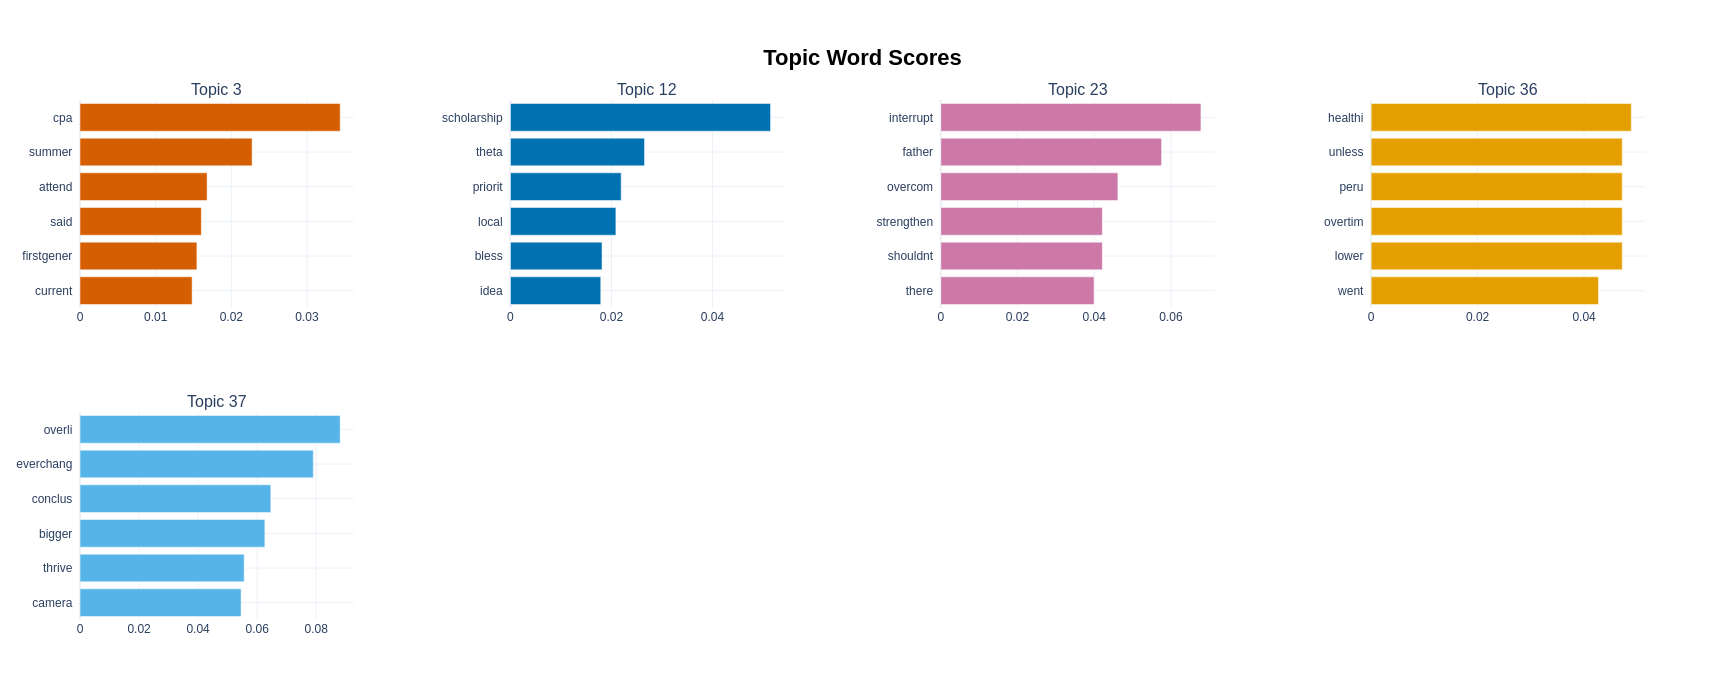

In [55]:
# plot significant topics that decrease chances
topic_model.visualize_barchart(topics=decrease_chances_topics, n_words=10, height=350, width=400)

In [56]:
# save plot of significant topics that decrease chances
# topic_model.visualize_barchart(topics=decrease_chances_topics, n_words=10, height=350, width=400).write_html('barchart_decrease_chances_topics.html')

In [57]:
# get sentences in these topics and save a file
decrease_chances_sencs = sentences_df[senc_topics_df.astype(int).isin(decrease_chances_topics)].copy()
decrease_chances_sencs = decrease_chances_sencs.fillna('')
decrease_chances_sencs = decrease_chances_sencs.stack().reset_index(drop=True)
decrease_chances_sencs = decrease_chances_sencs[decrease_chances_sencs.str.len() > 0]
# decrease_chances_sencs.to_frame().to_csv('decrease_chances_sencs.csv', index=False)
decrease_chances_sencs

12      I became more computer literate, got better at...
51      However, I am a motivated student with aspirat...
95      Being a first-generation college student, I di...
138     This made it difficult to really enjoy school,...
139     I even considered possibly transferring becaus...
                              ...                        
8444    Another challenge being online during the pand...
8480    My first semester was Spring 2020, and this wa...
8483    I experienced uncertainty and doubt about gett...
8485    This increased my fears, but I know that I had...
8562    It was harder for professors to lecture in a w...
Length: 180, dtype: object

In [58]:
# get odds_ratios of significant topics that increase chances
increase_chances_topics_odds_ratios = significant_topics_odds_ratios[significant_topics_odds_ratios > 1]
increase_chances_topics_odds_ratios = increase_chances_topics_odds_ratios.sort_values(ascending=False)
increase_chances_topics_odds_ratios

topic_9    4.820542e+10
topic_1    4.679752e+03
dtype: float64

In [59]:
# get significant topics that increase chances
increase_chances_topics = increase_chances_topics_odds_ratios.index.to_series().str.split('_').apply(lambda x: x[-1]).values.astype(int).tolist()
increase_chances_topics = sorted(increase_chances_topics)
increase_chances_topics

[1, 9]

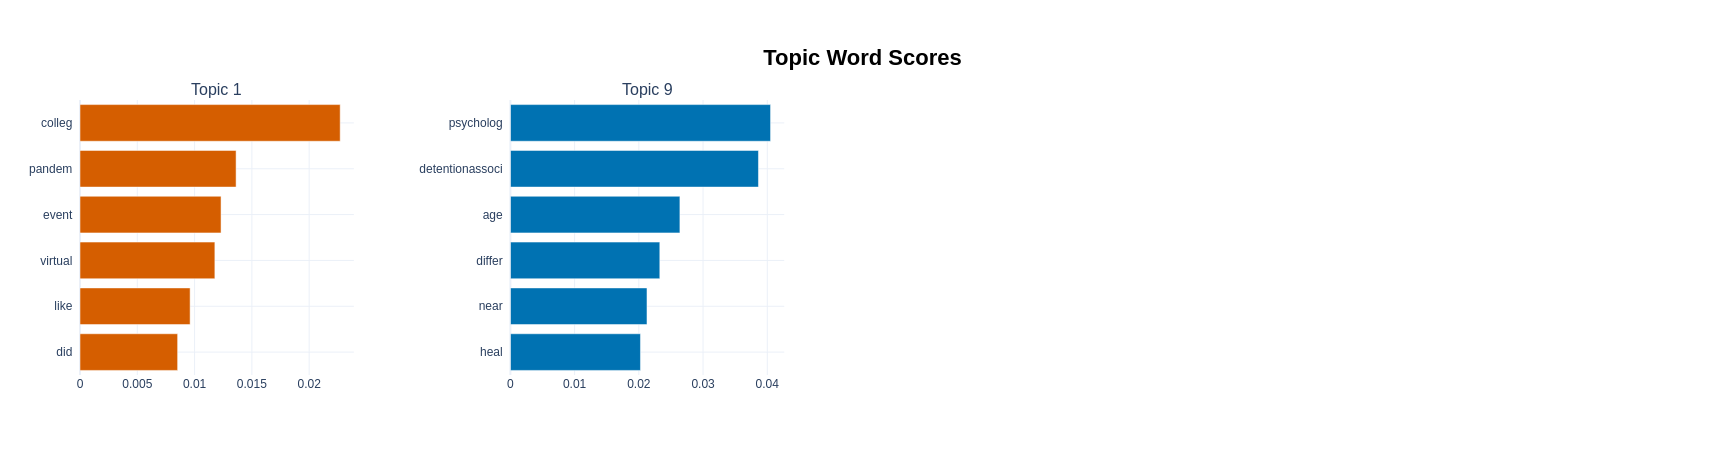

In [60]:
# plot significant topics that increase chances
topic_model.visualize_barchart(topics=increase_chances_topics, n_words=10, height=350, width=400)

In [61]:
# save plot of significant topics that increase chances
# topic_model.visualize_barchart(topics=increase_chances_topics, n_words=10, height=350, width=400).write_html('barchart_increase_chances_topics.html')

In [62]:
# get sentences in these topics and save a file
increase_chances_sencs = sentences_df[senc_topics_df.astype(int).isin(increase_chances_topics)].copy()
increase_chances_sencs = increase_chances_sencs.fillna('')
increase_chances_sencs = increase_chances_sencs.stack().reset_index(drop=True)
increase_chances_sencs = increase_chances_sencs[increase_chances_sencs.str.len() > 0]
# increase_chances_sencs.to_frame().to_csv('increase_chances_sencs.csv', index=False)
increase_chances_sencs

94      COVID set my family back a lot financially to ...
195                         My self-image was compromised
262     While not knowing how I would pay for college,...
352     Also, pursuing my career in either internal au...
357     Classes that show people how to plan, will set...
                              ...                        
8366    More importantly, I realized that I needed to ...
8391    Technology is the sum of skills, methods, and ...
8478    After immigrating to the United States, I mana...
8484    I was required to take a readiness test to see...
8566    With this challenge, I have always managed to ...
Length: 182, dtype: object

In [63]:
# get the topics that decrease chances the most (ignoring statistical significance)
bottom_k_topics = reg.params.sort_values()[:k_topics].index.to_series().str.split('_').apply(lambda x: x[-1]).astype(int).tolist()
bottom_k_topics

[42, 29, 12, 23, 11]

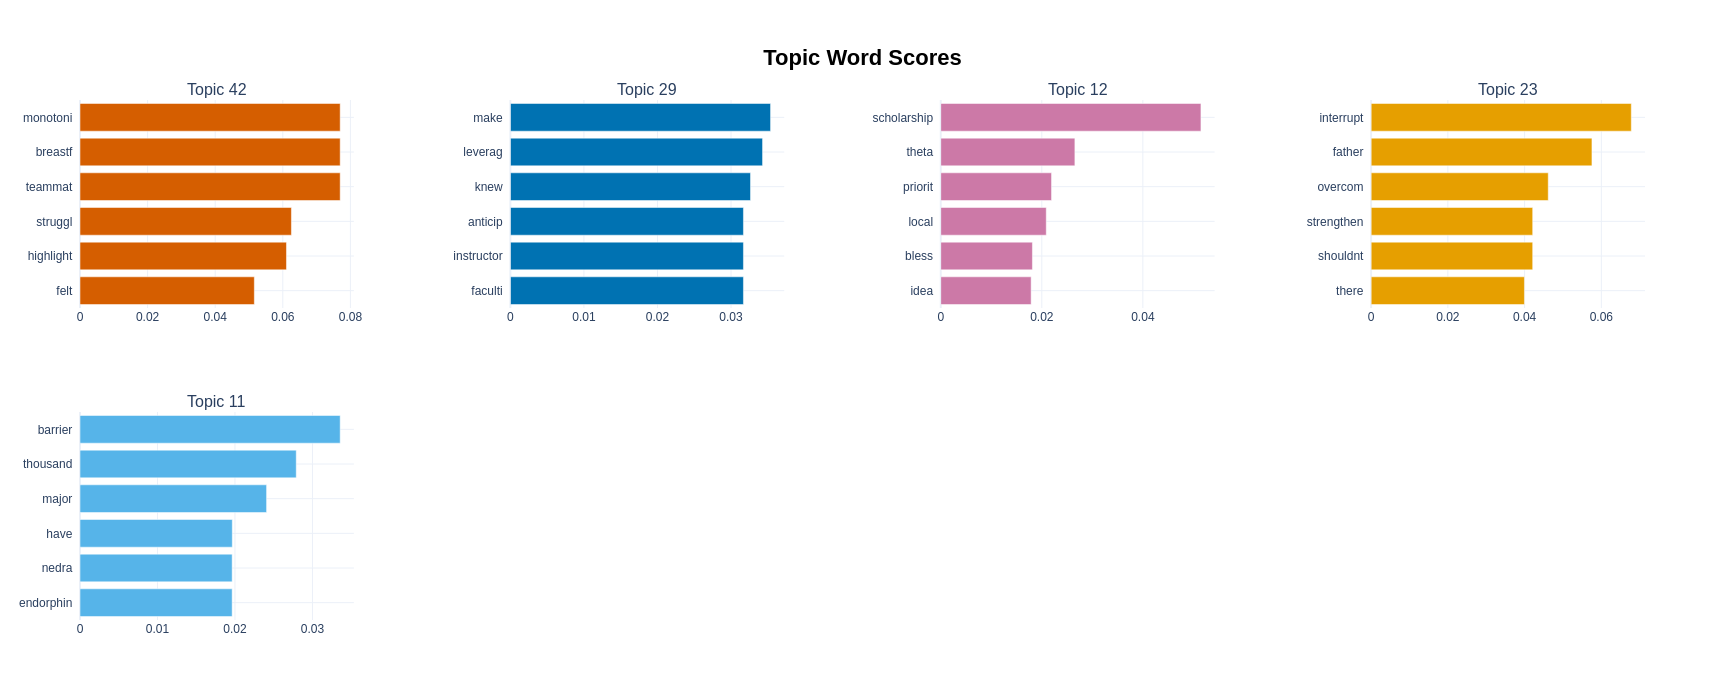

In [64]:
# plot topics that decrease chances the most (ignoring statistical significance)
topic_model.visualize_barchart(topics=bottom_k_topics, n_words=10, height=350, width=400)

In [65]:
# save plot of significant topics that increase chances
# topic_model.visualize_barchart(topics=bottom_k_topics, n_words=10, height=350, width=400).write_html('barchart_bottom_k_topics.html')

In [66]:
# get sentences in these topics and save a file
bottom_k_sencs = sentences_df[senc_topics_df.astype(int).isin(bottom_k_topics)].copy()
bottom_k_sencs = bottom_k_sencs.fillna('')
bottom_k_sencs = bottom_k_sencs.stack().reset_index(drop=True)
bottom_k_sencs = bottom_k_sencs[bottom_k_sencs.str.len() > 0]
# bottom_k_sencs.to_frame().to_csv('bottom_k_sencs.csv', index=False)
bottom_k_sencs

139     I even considered possibly transferring becaus...
265     Although I was unemployed, I was blessed to re...
699                           I have some new hobbies now
863     I quickly built relationships in the club and ...
907     A wake-up call came in the form of my younger ...
916     Why didn't I study what truly piqued my intere...
1055    Running to overcome anything that keeps me fro...
1212    Although it was not what I hoped for, I tried ...
1338    As small as the issue may sound, it was one of...
1472    Instead, we were not allowed to return to scho...
1566    My fall semester we were able to hold one clas...
1726      My mother couldn't visit as often as she wanted
1938    In no way was I prepared for such an abrupt in...
1989    Dealing with senior year, my first job, gettin...
2086    During my study sessions, I would tell myself ...
2164    However, I have been making used of the time a...
2166       We have turned to working remotely permanently
2248    While 

In [67]:
# get the topics that increase chances the most (ignoring statistical significance)
top_k_topics = reg.params.sort_values(ascending=False)[:k_topics].index.to_series().str.split('_').apply(lambda x: x[-1]).astype(int).tolist()
top_k_topics

[34, 32, 31, 9, 40]

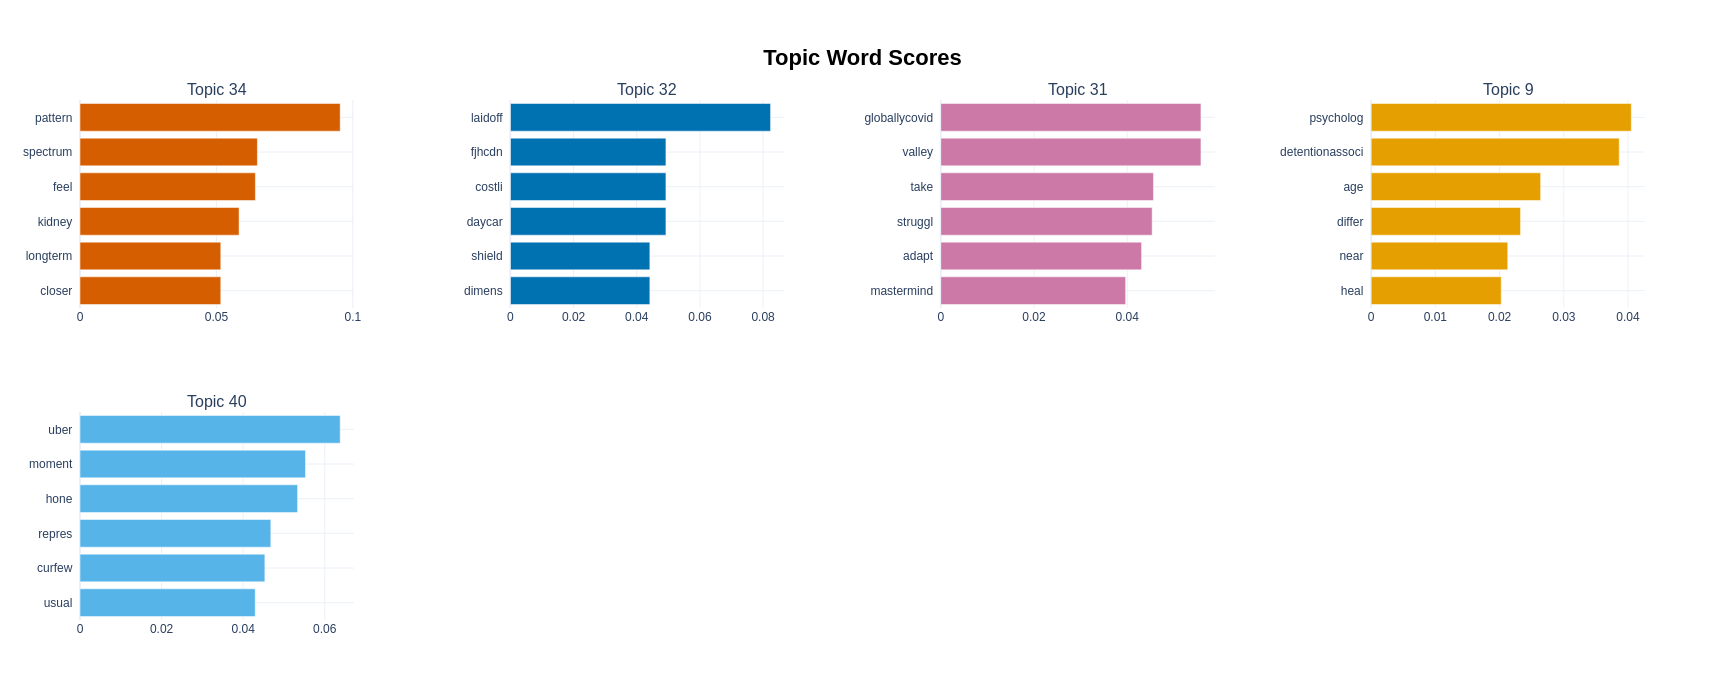

In [68]:
# plot topics that increase chances the most (ignoring statistical significance)
topic_model.visualize_barchart(topics=top_k_topics, n_words=10, height=350, width=400)

In [69]:
# save plot of significant topics that increase chances
# topic_model.visualize_barchart(topics=top_k_topics, n_words=10, height=350, width=400).write_html('barchart_top_k_topics.html')

In [70]:
# get sentences in these topics and save a file
top_k_sencs = sentences_df[senc_topics_df.astype(int).isin(top_k_topics)].copy()
top_k_sencs = top_k_sencs.fillna('')
top_k_sencs = top_k_sencs.stack().reset_index(drop=True)
top_k_sencs = top_k_sencs[top_k_sencs.str.len() > 0]
# top_k_sencs.to_frame().to_csv('top_k_sencs.csv', index=False)
top_k_sencs

195                         My self-image was compromised
479     I fell into a depression dwelling on things I ...
536     To live in a stress free and positive home tha...
654       These were the most emotionally difficult times
671            I had to adapt, create, innovate to evolve
789     Few months later, I was able to get over my st...
903     History has shown us that the people able to s...
1340    As I was doing my daily college routine from h...
1342    There was no break for me to enjoy the nature ...
2021    The pandemic has presented numerous challenges...
2237    I realized that I must adapt to the changing t...
2332    It started to seem that everything was falling...
2552    Not knowing where the world was heading during...
2677    I felt like a sponge that has been living in t...
2818    I am thankful for being able to serve as a lea...
3539    Blacks Lives Matter movement had a long-lastin...
3639    As mentioned before, change is inevitable but ...
3762    I thin